In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [55]:
csv_file = "pre_processed_reviews_svm.csv"
json_file = open('yelp_dataset/yelp_academic_dataset_review.json', 'r', encoding='utf-8')

def pre_process_json():
    object_count = 0
    for line in json_file:
        try:
            if object_count == 10000:
                break

            data = json.loads(line)

            # Data Transformation
            stars = int(data['stars'])
            useful = int(data['useful'])
            funny = int(data['funny'])
            cool = int(data['cool'])
            text = str(data['text'])

            neutral = funny + cool

            if useful == 0 or funny == 0 or cool == 0:
                continue
            else:
                sentiment_list = [useful, neutral]
                sentiment = sentiment_list.index(max(sentiment_list))
                if stars >= 3 and sentiment == 0:
                    reaction = 'satisfied considerable comment'
                elif stars >= 3 and sentiment == 1:
                    reaction = 'satisfied neutral comment'
                elif stars < 3 and sentiment == 0:
                    reaction = 'unsatisfied considerable comment'
                elif stars < 3 and sentiment == 1:
                    reaction = 'unsatisfied neutral comment'

            data = {'text': [text], 'Sentiment': [reaction]}
            df = pd.DataFrame(data)

            if object_count == 0:
                df.to_csv(csv_file, index=False)
            else:
                df.to_csv(csv_file, mode='a', header=False, index=False)

            object_count += 1

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue

pre_process_json()
json_file.close()

processed_data = pd.read_csv(csv_file)
print(processed_data.head())


                                                text  \
0  I am a long term frequent customer of this est...   
1  HOLY SMOKES!\n\nactual pumpkin pie mixed in wi...   
2  I thoroughly enjoyed the show.  Chill way to s...   
3  On a scale of one to things that are awesome, ...   
4  I've only had the cannolis here but they are a...   

                        Sentiment  
0     unsatisfied neutral comment  
1       satisfied neutral comment  
2       satisfied neutral comment  
3  satisfied considerable comment  
4       satisfied neutral comment  


In [56]:
sentiment_mapping = {
    "satisfied considerable comment": 0,
    "satisfied neutral comment": 1,
    "unsatisfied considerable comment": 2,
    "unsatisfied neutral comment": 3
}
processed_data['label'] = processed_data['Sentiment'].map(sentiment_mapping)

In [57]:
label_counts = processed_data['label'].value_counts()

sentiment_names = {v: k for k, v in sentiment_mapping.items()}
label_counts.index = label_counts.index.map(sentiment_names)

print("Sentiment Balance:")
print(label_counts)

Sentiment Balance:
label
satisfied neutral comment           5291
satisfied considerable comment      2909
unsatisfied considerable comment     921
unsatisfied neutral comment          879
Name: count, dtype: int64


In [58]:
from sklearn.utils import resample

df_majority_1 = processed_data[processed_data['label'] == 0]
df_majority_2 = processed_data[processed_data['label'] == 1]
df_minority_1 = processed_data[processed_data['label'] == 2]
df_minority_2 = processed_data[processed_data['label'] == 3]

df_minority_1_oversampled = resample(df_minority_1,
                                     replace=True,      # Sample with replacement
                                     n_samples=2909,    # Match the second majority class count
                                     random_state=42)   # Reproducible results

df_minority_2_oversampled = resample(df_minority_2,
                                     replace=True,
                                     n_samples=2909,
                                     random_state=42)

processed_data_balanced = pd.concat([df_majority_1, df_majority_2, df_minority_1_oversampled, df_minority_2_oversampled])

processed_data = processed_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# data = pd.read_csv(csv_file)
# X = data['text']
# y = data['Sentiment']
X = processed_data['text']
y = processed_data['label']



In [59]:
X

0        The beignets here were delicious. If you go in...
1        Don't shop here very often due to it's distanc...
2        I've been to the Rittenhouse location for dinn...
3        I was a bit weary about using a company withou...
4        When my bathroom ceiling fell in for the third...
                               ...                        
14013    Pork was great in the miso ramen, broth was ok...
14014    I can't believe they haven't remodeled this Sc...
14015    Absolutely loved going here for an ISC event. ...
14016    Their lunch special really is a good value. Fo...
14017    Great spot.  Light portions. But just enough f...
Name: text, Length: 14018, dtype: object

In [60]:
y

0        1
1        0
2        3
3        1
4        1
        ..
14013    1
14014    3
14015    1
14016    0
14017    1
Name: label, Length: 14018, dtype: int64

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=2000)  
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

svm_model = SVC(kernel='linear', C=0.1, random_state=42)  # Linear kernel for text classification
svm_model.fit(X_train_tfidf, y_train)

SVC(C=0.1, kernel='linear', random_state=42)

In [62]:
y_pred = svm_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


SVM Model Accuracy: 56.42%

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.00      0.00       592
           1       0.52      0.94      0.67      1062
           2       0.67      0.48      0.56       572
           3       0.64      0.53      0.58       578

    accuracy                           0.56      2804
   macro avg       0.58      0.49      0.45      2804
weighted avg       0.57      0.56      0.49      2804



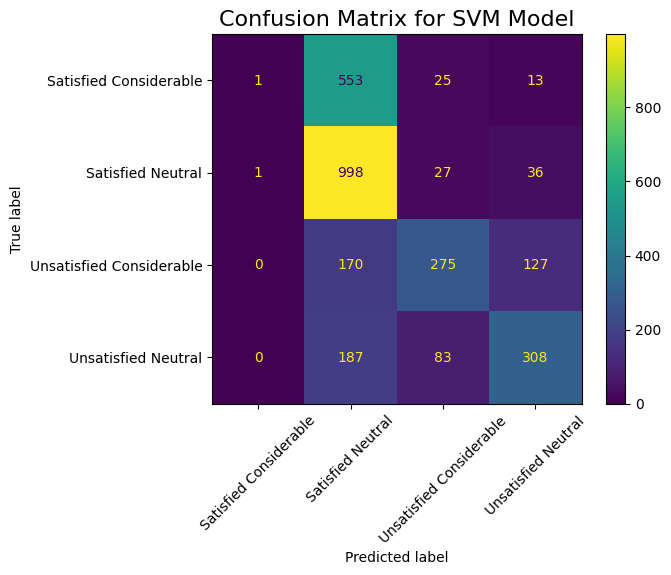

In [64]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])

label_mapping = {
    0: 'Satisfied Considerable',
    1: 'Satisfied Neutral',
    2: 'Unsatisfied Considerable',
    3: 'Unsatisfied Neutral'
}

display_labels = [label_mapping[label] for label in [0, 1, 2, 3]]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Confusion Matrix for SVM Model", fontsize=16)
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_2484\2690095280.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y, palette="viridis")


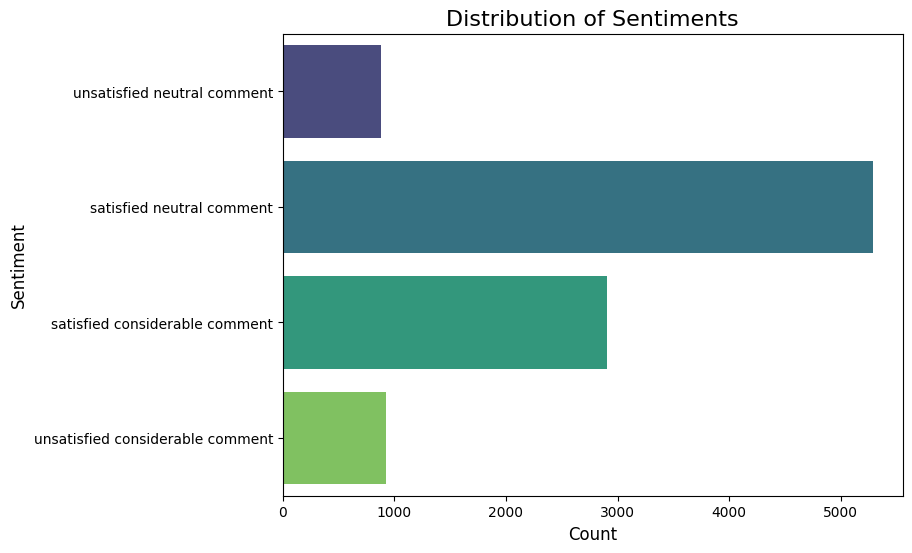

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(y, palette="viridis")
plt.title("Distribution of Sentiments", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Sentiment", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [ ]:
# # Step 7: Save vectorizer and model for future use
# import joblib

# joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
# joblib.dump(svm_model, 'svm_sentiment_model.pkl')

# print("Model and vectorizer saved successfully.")